In [1]:
import os
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'

In [4]:
from pathlib import Path
import os
import scipy.io as sio
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
cisqPath = Path("/home/mrpaw/Documents/mag_databases/CISQ")



distortions: noise, jpeg, jpeg2000, fnoise, blur, contrast
folders: awgn, blur, contrast, fnoise, jpeg, jpeg2000

For some reason noise is -> awgn?????
distortions: noise, jpeg, jpeg2000, fnoise, blur, contrast
    folders: awgn,  jpeg, jpeg2000, fnoise, blur, contrast,   


In [14]:
data =  pd.read_csv(cisqPath / "csiq.DMOS.fixed.csv")
data['dmos'][1]

np.float64(0.206)

In [19]:
from torch.utils.data import Dataset
import torch;
from typing import Tuple
from PIL import Image
import matplotlib.pyplot as plt

class CISQDataset(Dataset):
  csvToFolder = {
    "noise": "awgn",
    "jpeg": "jpeg",
    "jpeg 2000": "jpeg2000",
    "fnoise" : "fnoise",
    "blur": "blur",
    "contrast": "contrast"
  }

  csvToFile = {
    "noise": "AWGN",
    "jpeg": "JPEG",
    "jpeg 2000": "jpeg2000",
    "fnoise" : "fnoise",
    "blur": "BLUR",
    "contrast": "contrast"
  }

  def __init__(self, path:Path, train:bool, transform:torch.nn.Module = None, testSize = 0.2) -> None:
    super().__init__()
    self.train = train
    self.path = path
    self.dataPath = path / "csiq.DMOS.fixed.csv"
    self.imgsPaths = path / "dst_imgs"

    self.data =  pd.read_csv(self.dataPath)
    length = len(self.data["dmos"])
    

    self.indexes = np.arange(start=0, stop=length) 

    i_train, i_test = train_test_split(self.indexes, test_size=testSize, random_state=21, shuffle=True)

    self.indexes = i_train if train else i_test
    
    self.transform = transform

  def __len__(self):
    return len(self.indexes)  

  def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
    i = self.indexes[index]
    distortType = self.data["dst_type"][i]
    distortAmount = self.data["dst_lev"][i]
    imgName = self.data["image"][i]
    dmos = self.data["dmos"][i]
    img_path = self.imgsPaths / self.csvToFolder[distortType] / f"{imgName}.{self.csvToFile[distortType]}.{distortAmount}.png"

    # print(img_path)
    img = Image.open(img_path)

    if(self.transform != None):
      img = self.transform(img)


    dmos = torch.tensor(dmos)

    return (img, dmos)
  
  # def sortFunc(self,path):
  #   filename = os.path.basename(path)
  #   m = re.match(r"img(\d+)\.bmp", filename)
  #   if m:
  #       return int(m.group(1))
  #   else:
  #       return float('inf')
    
  # def sortPaths(self,paths): 
  #   return  sorted(paths,key=self.sortFunc)
     

In [20]:
trainData = CISQDataset(cisqPath, True)

<class 'torch.Tensor'>
tensor(0.0170, dtype=torch.float64)


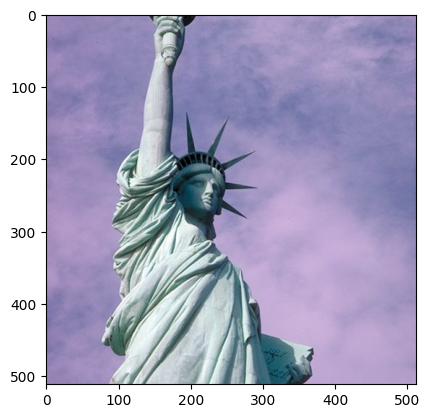

In [23]:
img, mos = trainData[4]
print(type(mos))
print(mos)
plt.imshow(img)